In [1]:
import pandas as pd
import numpy as np

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_score, plot_roc_curve, accuracy_score, recall_score
from graphviz import Source
from sklearn import tree
from IPython.display import SVG

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
df = pd.read_csv("/content/drive/MyDrive/Старт проект/test_data_regno.csv", sep = ";")

### Подготовка данных, выделение положительных и отрицательных примеров для обучающей выборки

Так как требуется минимизировать трудозатраты сотрудников по замене ГРЗ, то следовательно нужно найти все случаи, когда сотрудник сам изменяет ГРЗ. Т.е. где regno_recognize неравно regno

При этом положительными примерами(где нужно использовать новый алгоритм) из этой выборки будут те, в которых результат определения алгоритмом номера будет совпадать с итоговым значением алгоритма (regno_ai = regno), а распознавание ГРЗ камерой не будет совпадать (regno_recognize != regno)

In [5]:
df_positive = df[(df.regno_recognize != df.regno) & (df.regno_ai == df.regno)] # положительные примеры
df_positive.insert(0,'target', np.ones(df_positive.shape[0], dtype=int))

Отрицательными примерами(где алгоритм применять не стоит) будут те, в которых распознавание ГРЗ камерой совпадает с итоговы результатом (regno_recognize = regno), а новый алгоритм дает результат, отличающийся от итогового распознавания (regno_ai != regno).

При этом необходимо удалить все примеры, в которых оператор не смог распознать символ(в которых встречается "_" у regno), так как они не являются информативными, потому что предполагается то , что если человек по фотографии не смог распознать номер, то значит и алгоритм этого сделать не может.

In [6]:
df_negative = df[(df.regno_recognize == df.regno) & (df.regno_ai != df.regno) & ~(df.regno.str.contains('\_', regex=True))] #отрицательные примеры за исключением тех у кого и оператор не смог распознать
df_negative.insert(0,'target', np.zeros(df_negative.shape[0], dtype=int))

Объединяем положительные и отрицательные примеры

In [7]:
df_result = pd.concat([df_positive,df_negative]).reset_index().drop(columns = ["index"])

### Подготовка параметров на которых будет обучаться модель

Так как параметр result_code является ликом ( ставится уже после проверки ГРЗ сотрудником) уберем его.

Так же убераем параметр id операции, так как он неинформативен.

In [8]:
df_split_result = df_result.drop(columns = ["id", "result_code"], axis = 1)

Что бы было удобно моделе обрабатывать данные, то разобъем symbol_scores и length_scores по элементам и распишем как отдельные параметры.

Например: symbol_scores_1, symbol_scores_2

Максимальное количество символов в номере может равняться 10.
В номерах короче максимального, заполним нулями недостающие поля.

In [9]:
# Делаем symbol_scores массивом из float и дополняем до 10 знаков
def split_scores(x):
  split_x =  x.strip("[]").split(",")
  split_x = list(map(float,split_x))
  split_x += [0.0] * (10-len(split_x))
  return split_x

In [10]:
df_split_result["symbol_scores"] = df_split_result.symbol_scores.apply(split_scores)
symbol_scores = ["symbol_scores_" + str(i) for i in range(1,11)]
df_split_result[symbol_scores] = df_split_result.symbol_scores.values.tolist()

Так же поступаем вероятностью длины номера

In [11]:
# Делаем split_length массивом из float
def split_length(x):
  split_x =  x.strip("[]").split(",")
  split_x = list(map(float,split_x))
  return split_x

In [12]:
df_split_result["length_scores"] = df_split_result.length_scores.apply(split_length)
length_scores = ["length_scores_" + str(i) for i in range(11)]
df_split_result[length_scores] = df_split_result.length_scores.values.tolist()

Теперь можно спокойно удалить symbol_scores и length_scores, так как данные из них уже разложены.

In [13]:
df_split_result.drop(columns = ["symbol_scores", "length_scores"], axis = 1, inplace = True)

### Выбор алгоритма для обучения и метрики сравнения

Что бы сравнивать результаты работы алгоритмов, необходима метрика, по которой будет рассчитана правильно решенной задачи.

В качестве метрики предлагается использовать Precision, по причине:

Так как требование - минимизировать трудозатраты сотрудника, то следовательно важно, что бы в случае применения алгоритма было меньше ложных срабатываний ( следовательно ошибок первого рода).
Таким образом Precision показывает уверенность использования нового алгоритма.


Обучения проводятся на уверенности нового алгоритма в каждом символе и на уверенности в длине слова.

Для подсчета результатов будем использовать кросс валидацию.

In [14]:
X_for_cv = df_split_result[symbol_scores + length_scores]
y_for_cv = df_split_result["target"]

In [15]:
X_for_cv.head()

,symbol_scores_1,symbol_scores_2,symbol_scores_3,symbol_scores_4,symbol_scores_5,symbol_scores_6,symbol_scores_7,symbol_scores_8,symbol_scores_9,symbol_scores_10,...,length_scores_1,length_scores_2,length_scores_3,length_scores_4,length_scores_5,length_scores_6,length_scores_7,length_scores_8,length_scores_9,length_scores_10
0,0.999782,0.999895,0.999890,0.999968,0.999754,0.999676,0.999994,0.999968,0.999943,0.0,...,2.549491e-08,2.545317e-08,2.556420e-08,2.546721e-08,2.542925e-08,2.545759e-08,1.569068e-07,0.000023,0.999977,2.547318e-08
1,0.999679,0.999889,0.999945,0.999968,0.999813,0.999835,0.999760,0.999530,0.999959,0.0,...,1.279547e-08,1.280682e-08,1.273191e-08,1.288356e-08,1.284668e-08,1.282181e-08,4.594821e-07,0.000008,0.999991,1.277828e-08
2,0.999875,0.999929,0.999924,0.999895,0.999770,0.999627,0.999886,0.999754,0.999882,0.0,...,4.850030e-08,4.857205e-08,4.862887e-08,4.846895e-08,4.896281e-08,4.887109e-08,1.182716e-06,0.000048,0.999950,4.897523e-08
3,0.999919,0.999942,0.999929,0.999969,0.999956,0.999912,0.999996,0.999985,0.999927,0.0,...,2.977636e-08,2.974338e-08,2.980272e-08,2.991269e-08,3.017071e-08,3.001276e-08,1.712614e-07,0.000054,0.999945,2.989672e-08
4,0.994265,0.999911,0.999550,0.999770,0.999887,0.999640,0.999091,0.999119,0.000000,0.0,...,1.833720e-07,1.827866e-07,1.826682e-07,1.832346e-07,1.827559e-07,1.831301e-07,3.612299e-05,0.999897,0.000065,1.827899e-07


В качестве классификаторов рассматриваются:

1) RandomForestClassifier

2) DecisionTreeClassifier

3) LogisticRegression (можно применять, чтобы посмотреть какие признаки вносят наибольший эффект)

In [16]:
rf_clf = RandomForestClassifier(random_state = 42, max_depth = 15)

In [17]:
dt_clf = DecisionTreeClassifier(random_state = 42, max_depth = 15)

In [18]:
lr_clf = LogisticRegression(random_state=42, max_iter=1000)

In [19]:
cross_val_score(rf_clf,
                X_for_cv,
                y_for_cv,
                cv=5,
                scoring = "precision").mean()

0.8904659192056859

In [20]:
cross_val_score(dt_clf,
                X_for_cv,
                y_for_cv,
                cv=5,
                scoring = "precision").mean()

0.8735289222723495

In [21]:
cross_val_score(lr_clf,
                X_for_cv,
                y_for_cv,
                cv=5,
                scoring = "precision").mean()

0.8089237071135029

Хорошо себя показали алгоритмы случайный лес и дерево решений, следовательно в дальнейшем будем их использовать.

Для этой задаче деревья решений хорошо подходят, так как они описывают пороговые значения для уверенности модели.

Но случайный лес менее интерпретируем. 

Поэтому для наглядности выводятся коэффициенты логистической регрессии и дерево решений, для понимания, что оказывает влияние на принятие алгоритмом решения.



#### Интерпретация результатов

Для интерпретируемости не важна тестовая и валидационная выборка, поэтому модели строятся на всех данных.

In [22]:
dt_clf_for_display = DecisionTreeClassifier(random_state = 42, max_depth = 3, criterion = "entropy")

In [23]:
dt_clf_for_display.fit(X_for_cv, y_for_cv)

DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=42)

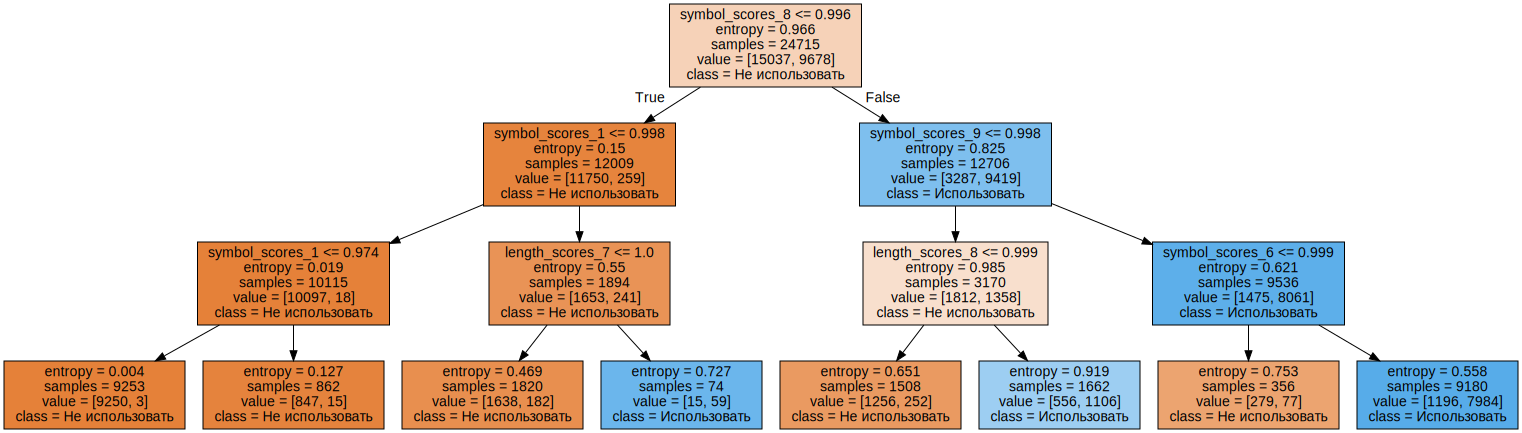

In [24]:
graph = Source(tree.export_graphviz(dt_clf_for_display, out_file=None, feature_names=list(X_for_cv), class_names=['Не использовать', 'Использовать'], filled=True))
display(SVG(graph.pipe(format='svg')))

Глубина 3 взята для наглядности, так как при 15 отображается плохо

In [25]:
lr_clf_for_coef = LogisticRegression(random_state=42, max_iter=1000)

In [26]:
lr_clf_for_coef.fit(X_for_cv, y_for_cv)

LogisticRegression(max_iter=1000, random_state=42)

Коэффициенты для symbol_scores

In [27]:
lr_clf_for_coef.coef_[0][0:10]

array([10.26754576,  7.94153892,  6.39167363,  6.46535048,  7.47603435,
        6.81830817,  6.63129087,  3.95435559, 13.64483553,  0.        ])

Коэффициенты для length_scores

In [28]:
lr_clf_for_coef.coef_[0][10:21]

array([-2.31479286e-04, -2.30936693e-04, -2.31024957e-04, -2.29997118e-04,
       -2.31689812e-04, -2.31380726e-04, -2.30980758e-04,  6.02528784e+00,
        3.48952829e+00, -9.54835064e+00, -2.29930355e-04])

По коэффициентам логистической регрессии можно сделать вывод:

  1) В коэф. длины наиболее информативные -  7, 8, 9.

  2) В коэф. символов наиболее информативные 1 и 9 символы. 


### Улучшение модели

Что бы улучшить модель добавим в нее дополнительные признаки, и уберем те, которые слабо влияют на результат

#### Дополнительные признаки

Используется учет букв входящих в каждый номер, так как скорее всего некоторые буквы алгоритм расспознает хорошо, некоторые не очень

In [29]:
from sklearn.preprocessing import MultiLabelBinarizer

In [30]:
def split_symbol(x):
  split_x =  x.strip("[]").replace('"', '').split(",\s*")[0]
  return split_x

In [31]:
df_split_result["symbols"] = df_split_result.symbols.apply(split_symbol)

In [32]:
mlb = MultiLabelBinarizer(sparse_output=False)

df_only_symbols = pd.DataFrame(mlb.fit_transform(df_split_result["symbols"].str.split(",\s*")),
                           columns=mlb.classes_,
                           index=df_split_result.index)

In [33]:
df_only_symbols.head(3)

,0,1,2,3,4,5,6,7,8,9,...,Е,К,М,Н,О,Р,С,Т,У,Х
0,0,0,1,0,0,0,0,1,1,0,...,0,0,1,0,0,0,0,0,0,0
1,1,0,0,1,0,0,0,1,0,1,...,0,1,1,1,0,0,0,0,0,0
2,1,1,0,0,0,1,0,1,1,0,...,0,0,0,0,0,0,1,0,1,0


In [34]:
df_only_symbols.columns

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'D', 'А', 'В', 'Е',
       'К', 'М', 'Н', 'О', 'Р', 'С', 'Т', 'У', 'Х'],
      dtype='object')

In [35]:
X_for_result_model = pd.concat([X_for_cv, df_only_symbols], axis=1)

#### Итоговая модель

Убираются коэффициенты которые показали малый вес на логистической регрессии

In [36]:
X_for_result_model.drop(columns = ["length_scores_0", "length_scores_1", "length_scores_2", "length_scores_3", "length_scores_4", "length_scores_5", "length_scores_6","length_scores_10"], axis = 1, inplace = True)

In [37]:
X_for_result_model.head()

,symbol_scores_1,symbol_scores_2,symbol_scores_3,symbol_scores_4,symbol_scores_5,symbol_scores_6,symbol_scores_7,symbol_scores_8,symbol_scores_9,symbol_scores_10,...,Е,К,М,Н,О,Р,С,Т,У,Х
0,0.999782,0.999895,0.999890,0.999968,0.999754,0.999676,0.999994,0.999968,0.999943,0.0,...,0,0,1,0,0,0,0,0,0,0
1,0.999679,0.999889,0.999945,0.999968,0.999813,0.999835,0.999760,0.999530,0.999959,0.0,...,0,1,1,1,0,0,0,0,0,0
2,0.999875,0.999929,0.999924,0.999895,0.999770,0.999627,0.999886,0.999754,0.999882,0.0,...,0,0,0,0,0,0,1,0,1,0
3,0.999919,0.999942,0.999929,0.999969,0.999956,0.999912,0.999996,0.999985,0.999927,0.0,...,0,0,0,1,1,0,0,0,0,0
4,0.994265,0.999911,0.999550,0.999770,0.999887,0.999640,0.999091,0.999119,0.000000,0.0,...,1,0,1,0,1,0,0,0,0,0


Используются модели, показавшие лучший результат на прошлом этапе

In [38]:
rf_clf = RandomForestClassifier(random_state = 42, max_depth = 15)

In [39]:
dt_clf = DecisionTreeClassifier(random_state = 42, max_depth = 15)

In [40]:
cross_val_score(rf_clf,
                X_for_result_model,
                y_for_cv,
                cv=5,
                scoring = "precision").mean()

0.8903421457631359

In [41]:
cross_val_score(dt_clf,
                X_for_result_model,
                y_for_cv,
                cv=5,
                scoring = "precision").mean()

0.8748173440262184

Алгоритм случайного леса показывает лучший результат (0.89), поэтому он будет использоваться для итогового предсказания

In [42]:
rf_clf.fit(X_for_result_model,y_for_cv)

RandomForestClassifier(max_depth=15, random_state=42)

### Проверка улучшения работы 

Что бы проверить улучшится ли результат при применении модели, необходимо применить обученную модель для всех данных.

Кол-во записей всего:

In [43]:
df.shape[0]

194214

Записи, в которых изначально камера распознала верно

In [44]:
df[(df.regno_recognize == df.regno)].shape[0]

183103

Записи,  в которых изначально оказался верен новый алгоритм

In [45]:
df[(df.regno_ai == df.regno)].shape[0]

176351

Следовательно, всегда новый алгоритм применять невыгодно, поэтому сформировано решающее правило на основе деревьев решений, в каких случаях использовать новый алгоритм, а вкаких нет.

Что бы использовать разработанную модель(решающее правило), преобразуем данные для входа в модель.

In [46]:
df_for_test = df.copy()

In [47]:
df_for_test["symbol_scores"] = df_for_test.symbol_scores.apply(split_scores)
df_for_test[symbol_scores] = df_for_test.symbol_scores.values.tolist()
df_for_test["length_scores"] = df_for_test.length_scores.apply(split_length)
df_for_test[length_scores] = df_for_test.length_scores.values.tolist()

In [48]:
df_for_test["symbols"] = df_for_test.symbols.apply(split_symbol)
mlb = MultiLabelBinarizer(sparse_output=False)

df_only_symbols_for_test = pd.DataFrame(mlb.fit_transform(df_for_test["symbols"].str.split(",\s*")),
                           columns=mlb.classes_,
                           index=df_for_test.index)

In [49]:
X_for_test = pd.concat([df_for_test, df_only_symbols_for_test], axis=1)
X_for_test.drop(columns = ["id",
                           "camera_id",
                           "time_check",
                           "regno_recognize",
                           "regno_ai",
                           "regno",
                           "result_code",
                           "symbols",
                           "symbol_scores",
                           "length_scores",
                           "length_scores_0",
                           "length_scores_1", 
                           "length_scores_2", 
                           "length_scores_3", 
                           "length_scores_4", 
                           "length_scores_5", 
                           "length_scores_6",
                           "length_scores_10",], axis = 1, inplace = True)

Теперь данные можно подать в модель, чтобы она решила, когда применять новый алгоритм(число 1), а когда нет (число 0)

In [50]:
use_new_alg =  rf_clf.predict(X_for_test)

In [51]:
use_new_alg

array([1, 1, 1, ..., 1, 1, 1])

Получился вектор из 0 и 1 

1 - нужно использовать новый алгоритма

0 - не нужно использовать

Соединим этот вектор с исходной таблицей для подсчета результатов

In [52]:
df_new = pd.concat([df.copy(), pd.Series(use_new_alg,name='Use_alg')], axis = 1)

In [53]:
df_new.head()

,id,camera_id,time_check,regno_recognize,regno_ai,regno,result_code,symbols,symbol_scores,length_scores,Use_alg
0,1,844,00:00:00,У991КВ799,У991КВ799,У991КВ799,0,"[""У"", ""9"", ""9"", ""1"", ""К"", ""В"", ""7"", ""9"", ""9""]","[0.9999366998672485, 0.9999223947525024, 0.999...","[0.000000034831597162110484, 0.000000034835451...",1
1,2,2516,00:00:00,О019УК177,О019УК177,О019УК177,0,"[""О"", ""0"", ""1"", ""9"", ""У"", ""К"", ""1"", ""7"", ""7""]","[0.9998993873596191, 0.999862790107727, 0.9999...","[0.0000000068477667980459955, 0.00000000683332...",1
2,3,2476,00:00:00,Е175АК150,Е175АК150,Е175АК150,0,"[""Е"", ""1"", ""7"", ""5"", ""А"", ""К"", ""1"", ""5"", ""0""]","[0.9997256398200989, 0.9999269247055054, 0.999...","[0.000000002039653557162069, 0.000000002043387...",1
3,4,1251,00:00:01,Т359ОН799,Т359ОН799,Т359ОН799,0,"[""Т"", ""3"", ""5"", ""9"", ""О"", ""Н"", ""7"", ""9"", ""9""]","[0.9998781681060791, 0.9998764991760254, 0.999...","[0.00000002880540606042814, 0.0000000289985120...",1
4,5,2516,00:00:01,В521СУ750,В521СУ750,В521СУ750,0,"[""В"", ""5"", ""2"", ""1"", ""С"", ""У"", ""7"", ""5"", ""0""]","[0.999920129776001, 0.9999333620071411, 0.9999...","[0.000000009300508807541519, 0.000000009201486...",1


Теперь, необходимо посчитать когда разработанная модель (решающее правило) сработала правильно, а когда нет.

Случаи, когда мы заменяем значения камеры на значения нового алгоритма (regno_ai), и это решение оказывается верным (regno_ai = regno)

In [54]:
df_new[(df_new.Use_alg == 1) & (df.regno_ai == df.regno)].shape[0]

171515

Случаи, когда мы оставляем значение камеры, алгоритм не используем(regno_recognize), и это решение оказывается верным (regno_recognize = regno)

In [55]:
df_new[(df_new.Use_alg == 0) & (df.regno_recognize == df.regno)].shape[0]

20218

В итоге имеем 171515 + 20218  = 191733 верных случаев

Если сравнивать:

1)  с работой обычной камеры 183103 < 191733 Выигрыш: 8630 случаев

2)  с заменой всегда на алгоритм 176351 < 191733 Выигрыш: 15382 случаев

Если брать процентное соотнешения правильности принятия решений применения нового алгоритма, то это:

191733/194214(это случаев всего) = 0.987

### Вывод

Вывод:

  1) Построена модель, определяющее правило изменения номера ГРЗ с распознанного камерой, на распознанный новым математическим аппаратом.

  2) Критериями замены являются значения в узалах дерева. Такое деление обосновано уменьшением энтропии (или джини критерия).

  3) Правило работает для 98% случаев в выборке. Экономия по справнению с работой камеры 8630 случаев.